# Inf2 - Foundations of Data Science
## Week 10: Scikit-learn - K-Nearest Neighbours

**Learning outcomes:** 
In this lab you will learn how to apply KNN to a data set using the scikit-learn library. By the end of the lab you should be able to:

- explain how *K* can be chosen appropriately, 
- explain the importance between training, testing and validation data.

The end of semester is near, you have worked hard, and some might think about celebrating it with a nice dinner and a glass of wine (other beverages are available). In this lab, we will try to predict the quality of wine based on several characteristics, and test whether price alone is a good predictor of good wine.

**Data set information:** The data set is taken from [UCI](https://archive.ics.uci.edu/ml/datasets/wine+quality), but was originally used in [Cortez et al. 2009](https://www.sciencedirect.com/science/article/pii/S0167923609001377).

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Importing sklearn functions
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans

## 10.A About K-Nearest neighbours

KNN is a supervised machine learning algorithm. KNN can be used for regression as well as classification problems. In this lab, we will use it for classification, as each wine has one of a number of distinct ratings.

Suppose we are presented with a previously unseen data point, but we do not know its class. K-Nearest Neighbour predicts that the class (or label) of this point depends on the labels of the *K* data points closest to it.  This definition prompts two questions:

- How do we chose the number of neighbours?
- How do we weight the "votes" of each neighbour on the classification. It seems reasonable that a neighbour closer to the unseen data point should have a larger weight than one which is further away.

There are numerous options to chose from when deciding what the "closeness" of two data points should be decided on. In the last lab, for example, we have already used the Euclidean distance, which is the square root of the sum of squares of the different coordinates of two data points, or in a formula: $\mathrm{euclideanDistance}((x_1, y_1),(x_2, y_2))= \sqrt{ (x_1-x_2)^2+(y_1-y_2)^2 }$

However, there are many more options to chose from:
- Manhattan distance (sum of absolute values of differences between points)
- Minkowski distance (the generalization of the Euclidean distance and Manhattan distance, by taking the $p$-th root and $p$-th power of the differences)
- Cosine distance (looking at the angle formed by two points and the origin).

To get a better idea of what the cosine distance is, and how it differs to the Euclidean distance, we can recommend this [blog post](https://cmry.github.io/notes/euclidean-v-cosine).

**Exercise 01:**

Before we get into how to chose the value of $K$, let us think about an example, where depending on $K$, the assignment of the cluster to a new data point will change. You can assume for this exercise that we do not weight the importance of the data point differently depending on the distance to the queried point.

- Plot a scatter plot with two clusters, and a queried data point, that depending on $K$ will be assigned to a different cluster. Plot a circle around the queried point that encapsulates all the neighbours taken into account for two different $K$ values.

0 0 0 0.14142135623730953
1 1 0.5 0.9848857801796105
2 1 1 1.2727922061357855


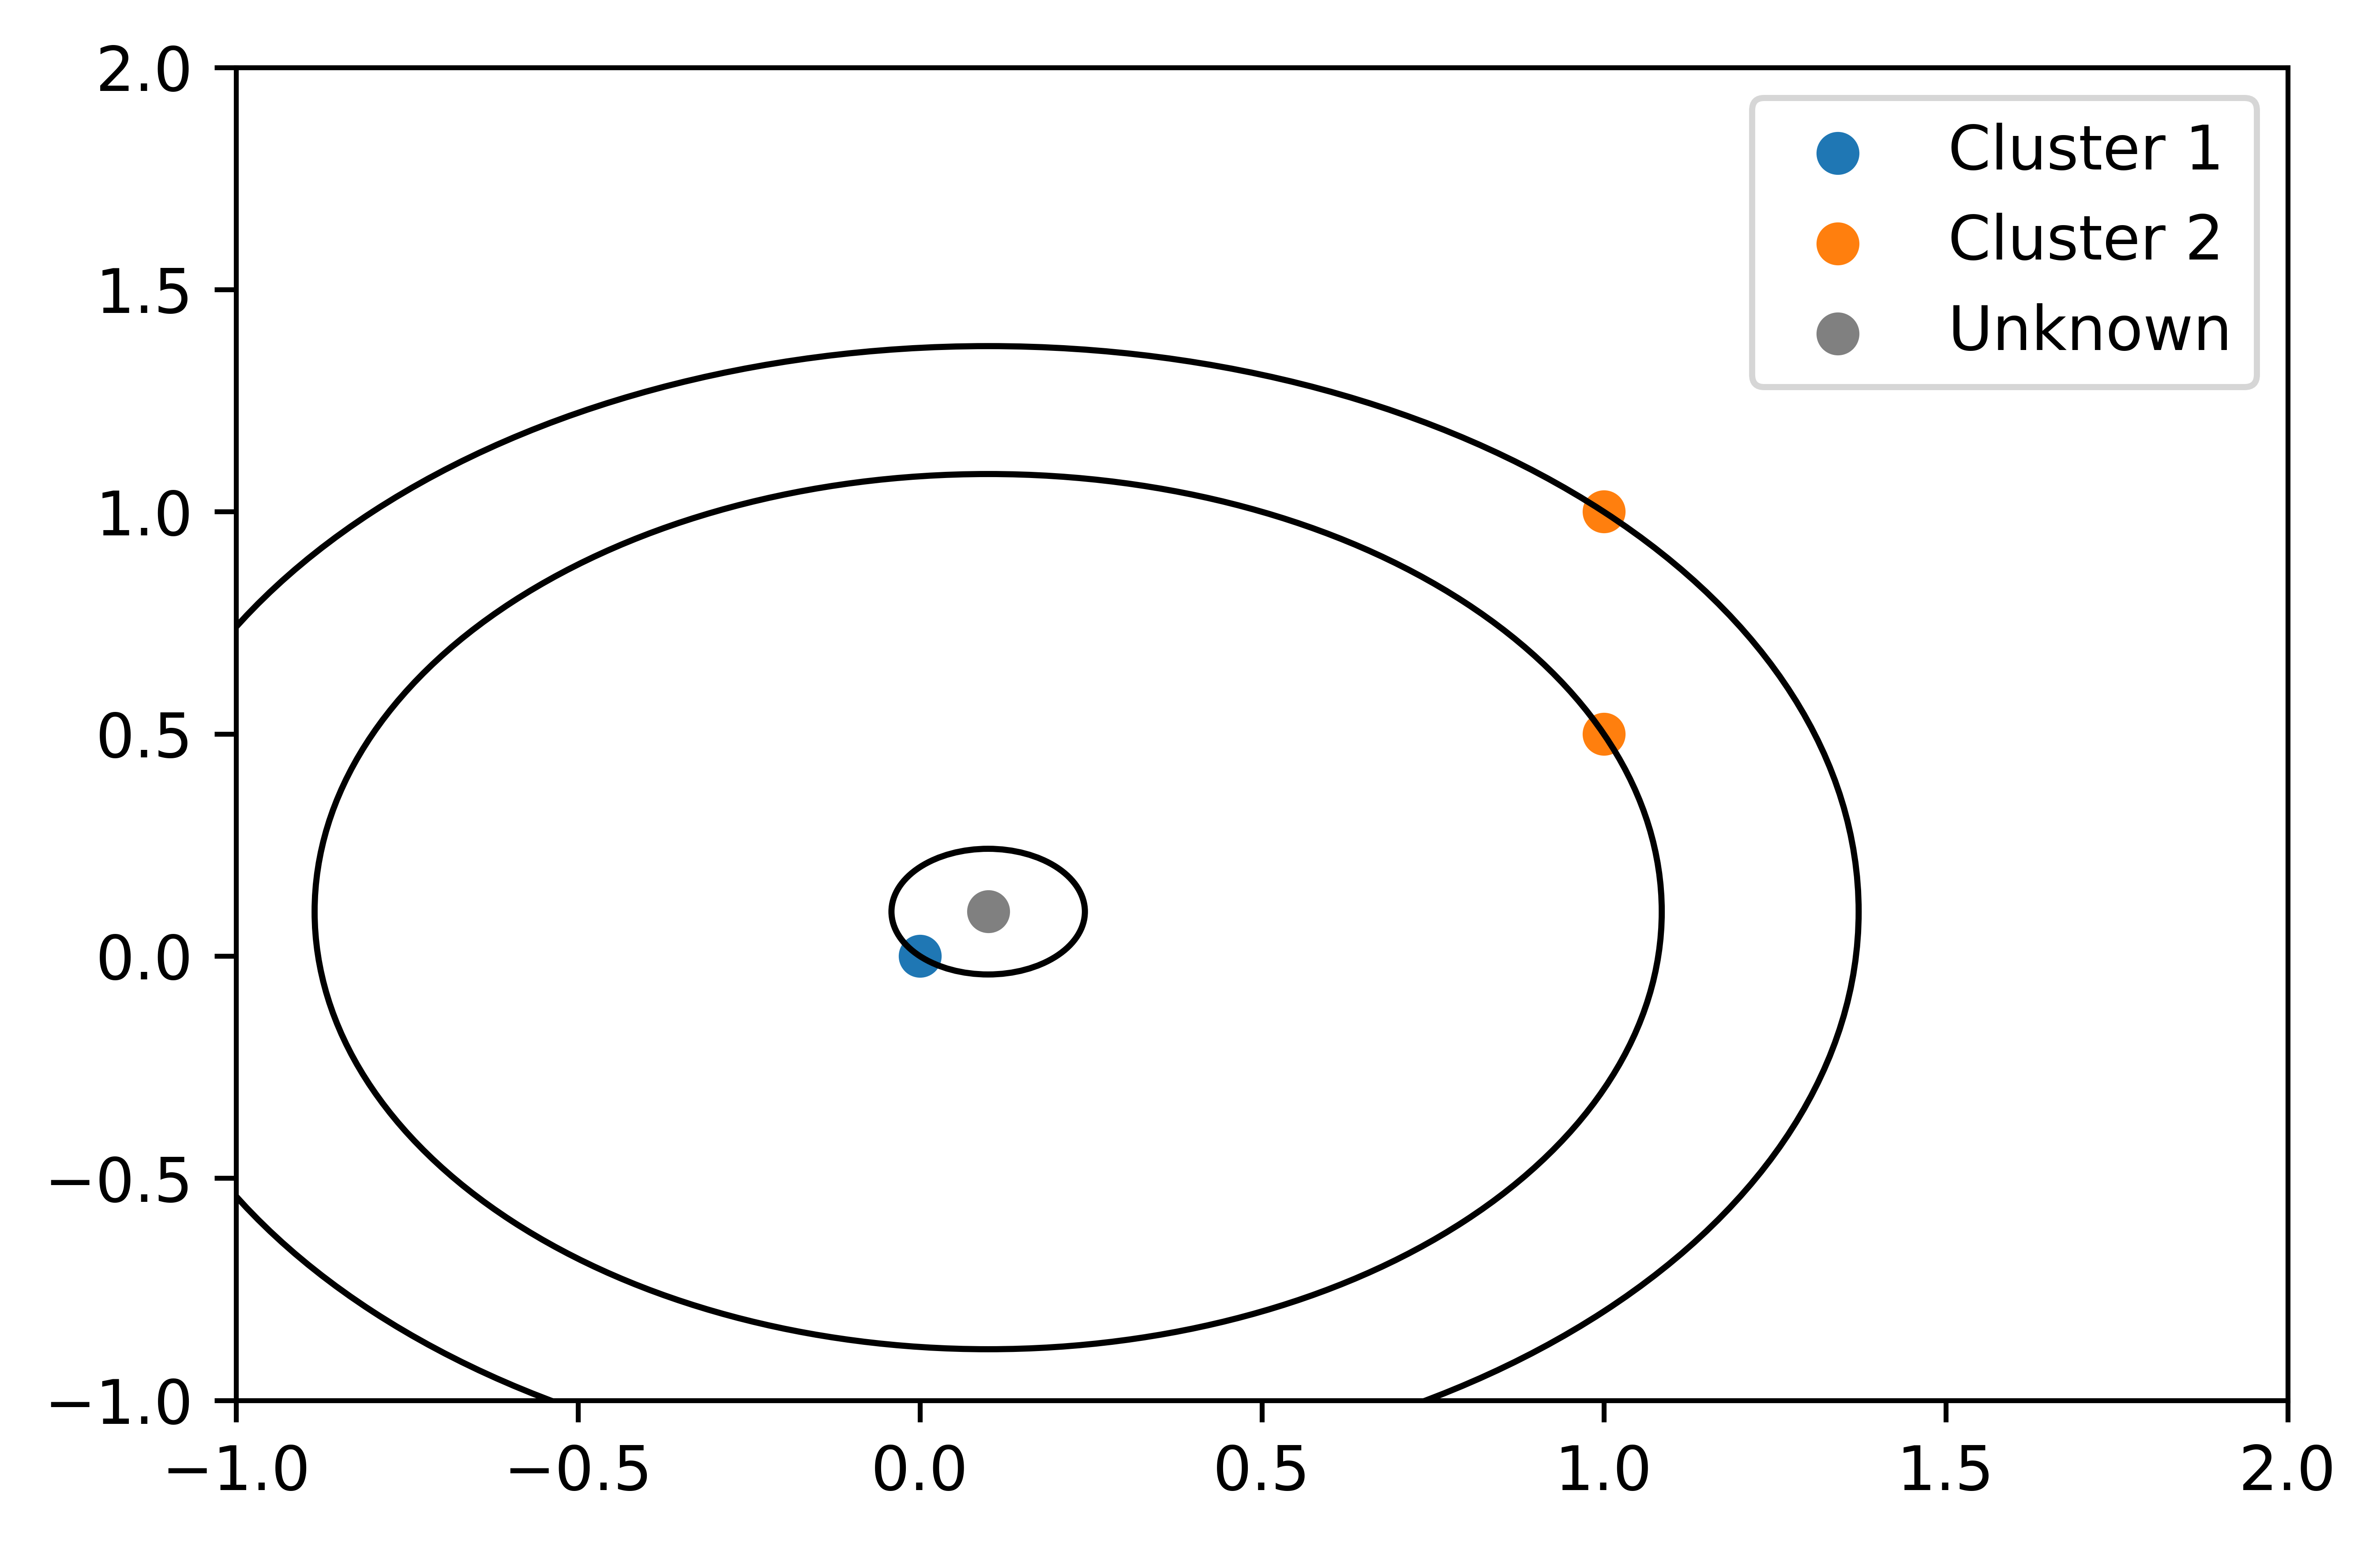

In [34]:
# Your code
from math import sqrt
xs1, ys1 = [0], [0]
xs2, ys2 = [1, 1], [0.5, 1]
fig = plt.figure()
fig.set_dpi(1000)
plt.scatter(xs1, ys1, label='Cluster 1')
plt.scatter(xs2, ys2, label='Cluster 2')
px, py = 0.1,0.1
plt.scatter(px, py, label='Unknown', c='gray')
all_xys = list(zip(xs1, ys1)) + list(zip(xs2, ys2))
d = lambda p: sqrt((p[0]-px)**2+(p[1]-py)**2)
all_xys.sort(key=d)
for i, (x, y) in enumerate(all_xys):
    plt.gca().add_artist(plt.Circle((px,py), d((x,y)), fill=False))
    print(i, x, y, d((x,y)))
plt.gca().set_ylim([-1,2])
plt.gca().set_xlim([-1,2])
plt.legend()
plt.show()


**Discussion:**

Discuss with your lab partner what happens when you choose $K$ too small and what happens when you choose $K$ too large.

Your answer:

We will try to answer these points in this lab.

## 10.B Data exploration and visualisation

**Exercise 02:**

- Load the `'winequality-red.csv'` data set.

It has a column `'quality'` with values between 3 and 8. Our goal is to only differentiate between low quality, medium quality, and high quality.

- Print out how many data entries you have per quality score.

It seems like there are very few very poor and excellent wines.

- Edit the scores in your dataset, such that all wines with quality 3-5 get score 0, wines with scores 6 get score 1, and all wines with better scores get a score 2. 
- Print out how many wines are in each new category.

In [53]:
# Your code
winequality_red = pd.read_csv('datasets/winequality-red.csv')
print(winequality_red['quality'].value_counts())
score = lambda x: 0 if x <= 5 else 1 if x <= 6 else 2
winequality_red = winequality_red.apply(lambda x: x.apply(score) if x.name == 'quality' else x)
print(winequality_red['quality'].value_counts())

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64
0    744
1    638
2    217
Name: quality, dtype: int64


**Exercise 04:**

Let us apply what we have learned in the last few labs.

- First store the quality score column in a separate variable.
- Apply PCA.
- Plot the scatter plot of first two PCs.

[3.10107182 1.92711489]


Text(0, 0.5, 'PC2')

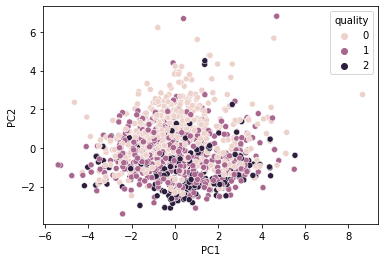

In [60]:
# Your code
labels = winequality_red['quality']
data = winequality_red.drop(columns=['quality'])
scaler = StandardScaler()
scaler.fit(data)
standardised = scaler.transform(data)
pca = PCA(n_components=2).fit(standardised)
pca_result = pca.transform(standardised)
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=qualities)
print(pca.explained_variance_)
plt.xlabel('PC1')
plt.ylabel('PC2')

## 10.C Training and testing data

The distinction of classes seems far less clear than in the last few labs. We will be running K-NN to classify the wines, but before that we need to create training and testing sets, which is your job. 

**Exercise 05:**
- Split the data into two sets, such that the training data contains 80% of the data and the test data contains 20%. You can use [sklearn's](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) native function. Optional: Write your own function, which randomly picks 80% of the data and stores it in a new data set. (Careful: We have already stored the score data into a different data set, either reload the data and store the score column after splitting, or make sure that you save the score data in the right order in a train and test Pandas series of its own.)

In [68]:
# Your code
train_data, test_data, train_labels, test_labels \
    = train_test_split(data, labels)
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(1199, 11)
(1199,)
(400, 11)
(400,)


Above, you have already discussed what the problems might be by choosing a bad $K$. So how do we choose $K$? Well, the answer sadly is there is no simple answer, and it will depend on your data, and the way of getting to the optimal solution is heuristic.

For example, you can run the KNN algorithm with different values of $K$, and plot the result on a graph, where on one axis, you have the values of $K$ and on the other axis you have the accuracy of the model. 

Scikit-learn has its built in KNN classifier. It works similar to the K-Means algorithm. That is, you create an instance of `KNeighborsClassifier()`, then you `.fit()` it with your training data, and finally you can `.predict()` on new data.
The first parameter of interest, is of course `n_neighbors=k`, which is set to 5 by default. The second parameter of interest is, as discussed above, the metric which we use to compute which neighbours are closest to a new data point. By default it is `metric='minkowski'`, in that case you need to define `p` the parameter of the Minkowski distance, which is set by default to 2. Thus, by default sklearn uses the Euclidean distance as a metric to compute the closest neighbours.
Finally, you can choose whether or not the distance of each neighbour should be used as a weight, to decide which neighbour's class should be weighted more. You can set it to `weights='distance'`, otherwise each neighbour will be weighted the same.

**Exercise 05:**

- Run KNN 100 times each time with a different $K$. Predict the classes of your test set, and compute the accuracy of each model. 
- Plot $K$ vs the accuracy of each model.

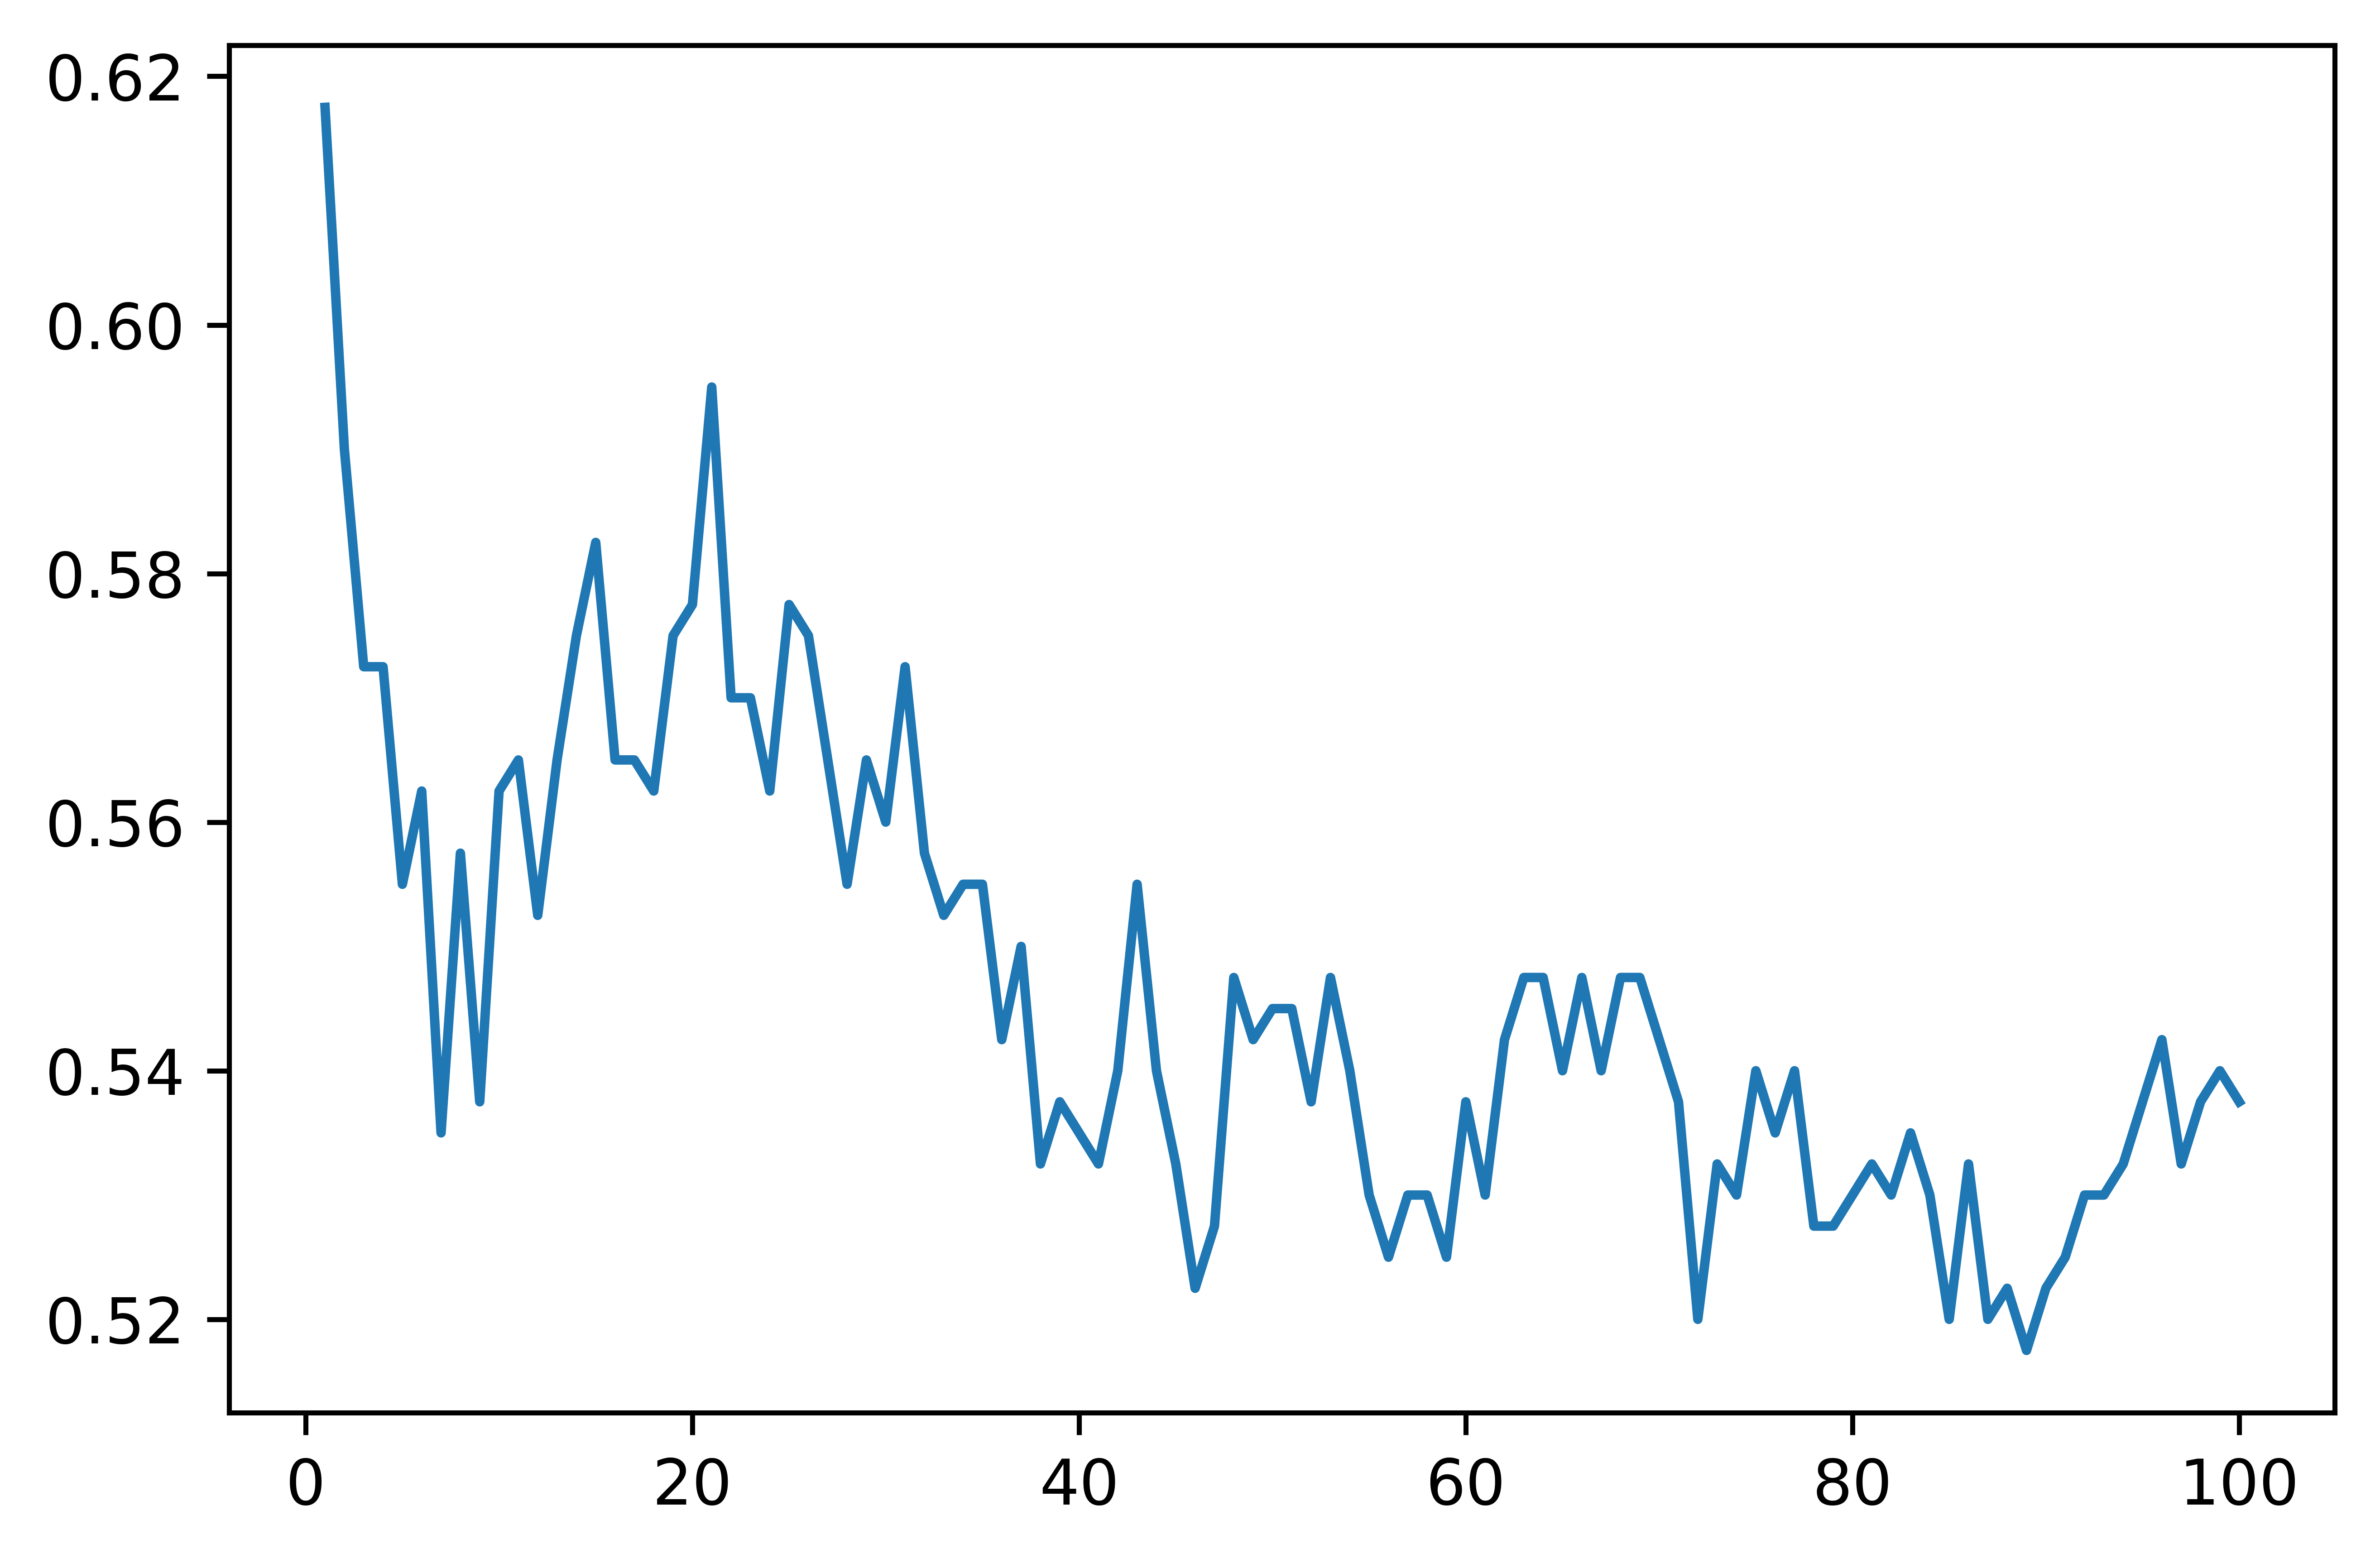

In [80]:
# Your code
from sklearn.metrics import accuracy_score
accuracies = []
for i in range(100):
    knn = KNeighborsClassifier(n_neighbors=i+1).fit(train_data, train_labels)
    predicted = knn.predict(test_data)
    accuracies.append(accuracy_score(test_labels, predicted))
plt.figure().set_dpi(1000)
plt.plot([i+1 for i in range(100)], accuracies)

**Discussion:**
You can now see for which $K$ you have the highest accuracy. The goal of machine learning, however, is that it generalizes well. Is the best model you found above, also the best model in general for new incoming data? Will you and your lab partner have the same plot? If you have several models with similar accuracy, which model would you choose?

Your answer:

## 10.D Cross validation

If one of your models achieved an accuracy of 80%, does that mean that you would get an accuracy of 80% on any unseen data? The answer is no. You will need to test it on unseen data first. However, the problem is that we have already used up all the data. 

This leads to the concept of validation, and the important difference between validation and test data. So the first step will be to split our data into three data sets: training data, validation data and test data (which is equivalent to future unseen data).

The problem is that if we split up our data, for example, 60% training data, 20% validation data, and 20% test data (which we are not allowed to touch until the end), we loose 20% of data, which we have previously used for training. That's where k-fold cross-validation comes into play. 

We first split the data set into training and testing data, and set the test set aside (e.g. 80-20 ratio). Then, we split the remaining training data randomly into $k$ equal parts. We've covered cross-validation briefly in the lectures, but there's also a [helpful description in the scikit-learn documentation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation).

**Remark:** Sadly the letters $k$ and $K$ are overloaded in the machine learning literature. In this lab, capital $K$ refers to the neighbours and $k$ refers to the number of splits we perform on the training data, but in the literature $k$ is often used for both.

We train our model $k$ times, such that we set one of the $k$ subsets aside (which is the validation data), train with the remaining $k$-1 parts of the training data, and report the accuracy, by predicting on the set aside validation data set. Then, we report the mean of all $k$ loops. We do this for all $K$ models. Then, we choose the model that had the best accuracy, and finally report the accuracy of our model, by predicting the outcome of the test data set, which we have set aside at the very beginning. 

If we choose $k$=4 we get the ratio back, we initial split it up with (i.e. 60-20-20).

Scikit-learn has a function that does all that for us: `cross_val_score()`, which we have already loaded above. The first parameter is the model object (you do not need to fit it in advance, the function does it automatically) you want to cross validate (you can use cross-validation for any learning algorithm). The second parameter is the training data (i.e. the 80% you have set aside in the beginning). The third parameter is the associated target value. Then, we specify with `cv=k` the number of folds we want to use, and finally, we specify based on what we want to score our models, e.g. `scoring='accuracy'`. The return value is an array of scores for each fold.

**Exercise 06:**

- Run cross-validation on your training data with 4 folds.
- Compute the mean of the accuracy of each fold.
- Plot the mean accuracy of each model.
- Choose the best model and report the accuracy of that model on the test data. (Careful: This time you need to fit it first.)

In [15]:
# Your code

**Discussion:**
We used the accuracy to score a model, what else could we score it on?

Your answer:

**Discussion:**

You have now trained your model several times. Discuss with your lab partner what the limitations/draw backs of KNN are.

Your answer:

## 10.E K-Means versus K-NN


**Discussion:** In the last lab we have seen how K-Means can be used to cluster data, leading to classification. Why wouldn't it be appropriate to run K-Means on this dataset?

Your answer:

This lab, is the last lab this semester, and we hope that you enjoyed the labs. However, we want to continuously improve. That is why **we really need your help**: Please fill out the following [survey](https://forms.office.com/Pages/ResponsePage.aspx?id=sAafLmkWiUWHiRCgaTTcYZmGMCx4KxlMjSTITqjdcXpUMFY4MktZWDJJNllSNDBERzJQTE9UVEVGTS4u), so that we can improve the labs for next year, and think of your feedback while we prepare the next semester labs.